In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-ct-cough/Split data to train test valid.py
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia114.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia156.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia241.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia279.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia147.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia93.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia377.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia258.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia124.jpg
/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset/CXR/Pneumonia/Pneumonia415.jpg


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


2025-10-10 15:41:55.184036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760110915.380385      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760110915.432545      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = "/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset"
modalities = ["CT", "CXR", "Cough sound"]
classes = ["Healthy", "LungsCancer", "Pneumonia", "covid"]
img_size = (224, 224)
batch_size = 16


In [4]:
from tensorflow.keras.preprocessing import image

def load_fused_image(ct_path, cxr_path, cough_path):
    ct = image.load_img(ct_path, target_size=img_size)
    cxr = image.load_img(cxr_path, target_size=img_size)
    cough = image.load_img(cough_path, target_size=img_size)
    
    ct = image.img_to_array(ct) / 255.0
    cxr = image.img_to_array(cxr) / 255.0
    cough = image.img_to_array(cough) / 255.0
    
    fused = np.concatenate([ct, cxr, cough], axis=-1)  # (224,224,9)
    return fused


In [5]:
import os

print(os.listdir(base_dir))


['CXR', 'CT', 'Cough sound']


In [6]:
train_X, train_y = [], []

for cls_idx, cls in enumerate(classes):
    for i in range(1, 401):
        ct_path = f"{base_dir}/CT/{cls}/{cls}{i}.jpg"
        cxr_path = f"{base_dir}/CXR/{cls}/{cls}{i}.jpg"
        cough_path = f"{base_dir}/Cough sound/{cls}/{cls}{i}.jpg" 
        
        if os.path.exists(ct_path) and os.path.exists(cxr_path) and os.path.exists(cough_path):
            fused_img = load_fused_image(ct_path, cxr_path, cough_path)
            train_X.append(fused_img)
            train_y.append(cls_idx)


In [7]:
print(" Num Image:", len(train_X))
if len(train_X) > 0:
    print("shape first image :", train_X[0].shape)


 Num Image: 1600
shape first image : (224, 224, 9)


In [8]:
train_X = np.array(train_X, dtype=np.float32)
train_y = tf.keras.utils.to_categorical(train_y, num_classes=len(classes))

print(train_X.shape, train_y.shape)


(1600, 224, 224, 9) (1600, 4)


In [9]:
valid_X, valid_y = [], []

for cls_idx, cls in enumerate(classes):
    for i in range(401, 451):  # من 401 إلى 450 لأنهم 50 صورة
        ct_path = f"{base_dir}/CT/{cls}/{cls}{i}.jpg"
        cxr_path = f"{base_dir}/CXR/{cls}/{cls}{i}.jpg"
        cough_path = f"{base_dir}/Cough sound/{cls}/{cls}{i}.jpg"
        
        if os.path.exists(ct_path) and os.path.exists(cxr_path) and os.path.exists(cough_path):
            fused_img = load_fused_image(ct_path, cxr_path, cough_path)
            valid_X.append(fused_img)
            valid_y.append(cls_idx)


In [10]:
valid_X = np.array(valid_X, dtype=np.float32)
valid_y = tf.keras.utils.to_categorical(valid_y, num_classes=len(classes))
print(valid_X.shape, valid_y.shape)


(200, 224, 224, 9) (200, 4)


In [11]:
test_X, test_y = [], []

for cls_idx, cls in enumerate(classes):
    for i in range(451, 501):  # من 451 إلى 500 لأنهم 50 صورة
        ct_path = f"{base_dir}/CT/{cls}/{cls}{i}.jpg"
        cxr_path = f"{base_dir}/CXR/{cls}/{cls}{i}.jpg"
        cough_path = f"{base_dir}/Cough sound/{cls}/{cls}{i}.jpg"
        
        if os.path.exists(ct_path) and os.path.exists(cxr_path) and os.path.exists(cough_path):
            fused_img = load_fused_image(ct_path, cxr_path, cough_path)
            test_X.append(fused_img)
            test_y.append(cls_idx)


In [12]:
test_X = np.array(test_X, dtype=np.float32)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=len(classes))
print(test_X.shape, test_y.shape)


(200, 224, 224, 9) (200, 4)


In [13]:
input_shape = (224, 224, 9)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.1),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(classes), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760110962.542851      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,956,804 (198.20 MB)

 Trainable params: 51,956,484 (198.20 MB)

 Non-trainable params: 320 (1.25 KB)

In [15]:
print("train_X shape:", train_X.shape)
print("valid_X shape:", valid_X.shape)
print("test_X shape:", test_X.shape)


train_X shape: (1600, 224, 224, 9)
valid_X shape: (200, 224, 224, 9)
test_X shape: (200, 224, 224, 9)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

In [17]:
history = model.fit(
    train_X, train_y,
    validation_data=(valid_X, valid_y),
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping_callback]
)


Epoch 1/50


I0000 00:00:1760110975.463693      97 service.cc:148] XLA service 0x7c19d4021940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760110975.464498      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760110975.976247      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.1354 - loss: 11.5114 

I0000 00:00:1760110983.305997      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5204 - loss: 7.1211 - val_accuracy: 0.6750 - val_loss: 1.3184
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8289 - loss: 0.3884 - val_accuracy: 0.8450 - val_loss: 1.0971
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8668 - loss: 0.3110 - val_accuracy: 0.8050 - val_loss: 0.7084
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8767 - loss: 0.2738 - val_accuracy: 0.9100 - val_loss: 0.3869
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8707 - loss: 0.2810 - val_accuracy: 0.9150 - val_loss: 0.3101
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8862 - loss: 0.2516 - val_accuracy: 0.9150 - val_loss: 0.2604
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8935 - loss: 0.2315 - val_accuracy: 0.9350 - val_loss: 0.2204
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9190 - loss: 0.1906 - val_accuracy: 0.93

In [18]:
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=0)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 93.50%
✅ Test Loss: 0.1280


In [19]:
y_pred_probs = model.predict(test_X)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_y, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


In [20]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1 Score : {f1*100:.2f}%")


Accuracy : 93.50%
Precision: 93.69%
Recall   : 93.50%
F1 Score : 93.48%


In [21]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


              precision    recall  f1-score   support

     Healthy       0.84      0.92      0.88        50
 LungsCancer       1.00      1.00      1.00        50
   Pneumonia       1.00      1.00      1.00        50
       covid       0.91      0.82      0.86        50

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



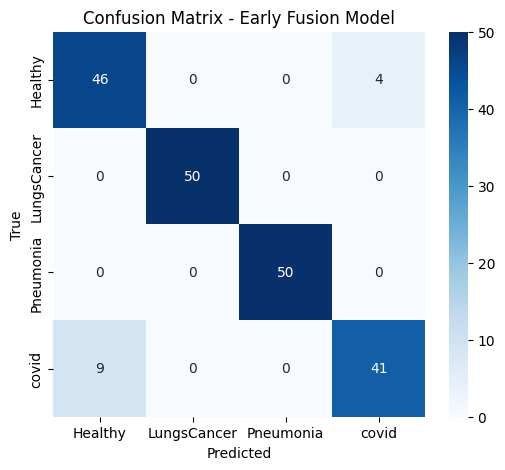

In [22]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Early Fusion Model")
plt.show()


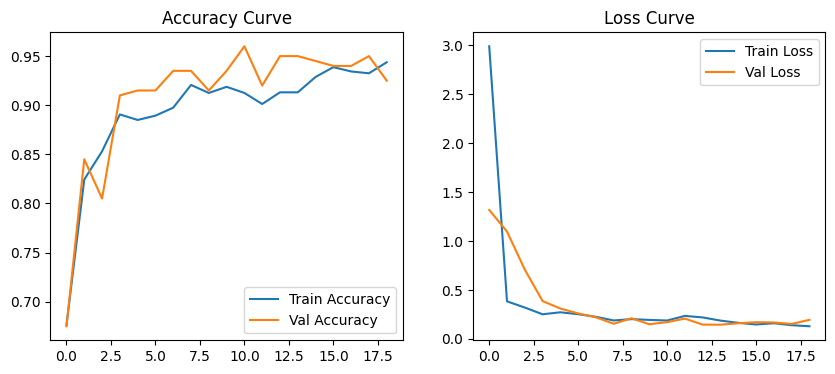

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curve')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

predictions = model.predict(valid_X)

In [ ]:
predictions_decoded = np.argmax(predictions, axis=1)


confidence_scores = np.max(predictions, axis=1) * 100


actual_decoded = np.argmax(valid_y, axis=1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


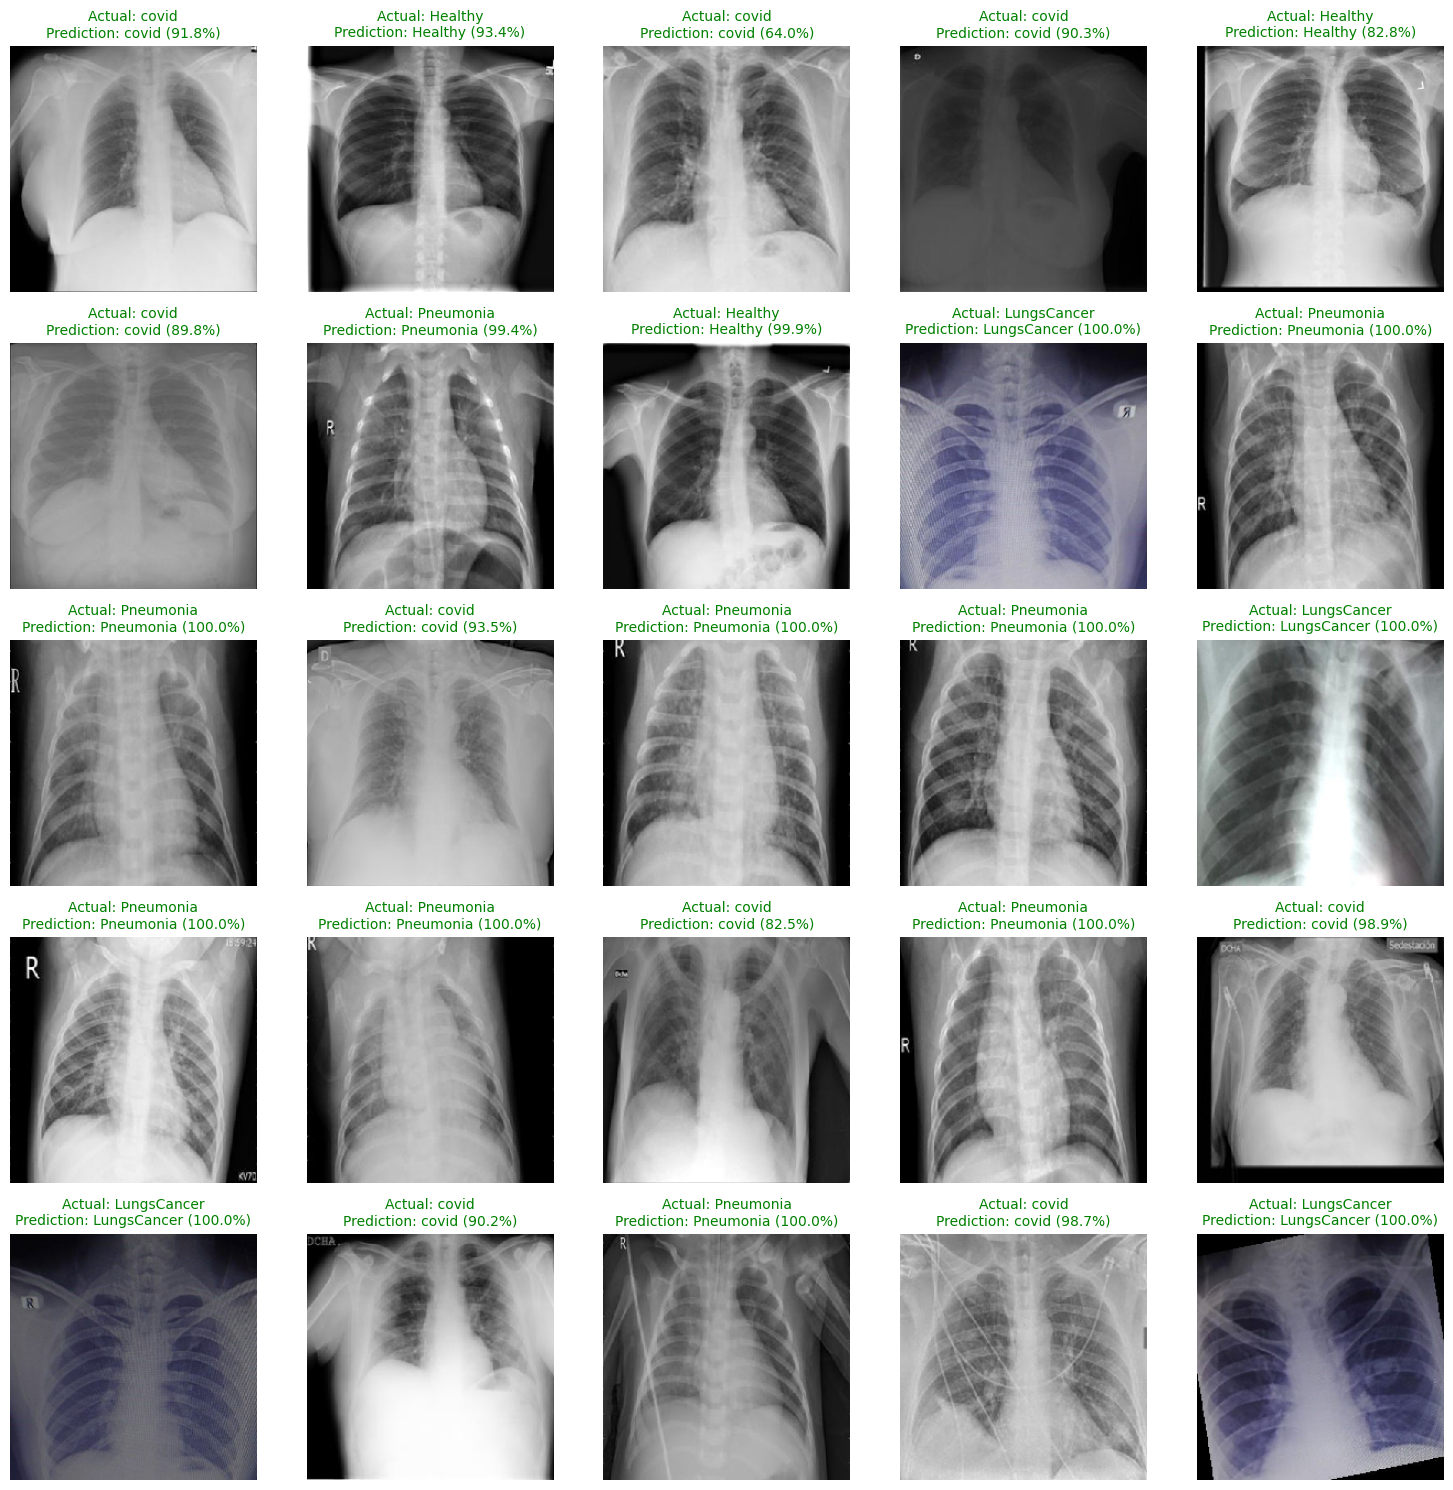

In [24]:

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten() 


random_indices = random.sample(range(len(valid_X)), 25)

for i, idx in enumerate(random_indices):
    ax = axes[i]

    image_to_show = valid_X[idx][:, :, 3:6]
    
  
    ax.imshow(image_to_show)
    ax.axis('off') 

    
    actual_label = classes[actual_decoded[idx]]
    predicted_label = classes[predictions_decoded[idx]]
    confidence = confidence_scores[idx]
    
   
    title_color = 'green' if actual_label == predicted_label else 'red'
    
  
    ax.set_title(
        f"Actual: {actual_label}\nPrediction: {predicted_label} ({confidence:.1f}%)",
        color=title_color,
        fontsize=10
    )


plt.tight_layout()
plt.show()